# Citation Usage Event Data

In [1]:
# basic defaults, including study dates, common SQL exclusions and parquet files for anonymized data
%run -i 'data-defaults.py'

## Overview

### Events by date and type

In [2]:
# show citationusage events by date and type
events_query = """
SELECT to_date(event_time) date, action, COUNT(*) count
FROM citationusage
WHERE wiki = 'enwiki'
{}
AND to_date(event_time) >= '{}'
AND to_date(event_time) <= '{}'
AND useragent_is_bot = FALSE
GROUP BY to_date(event_time), action
ORDER BY to_date(event_time)
"""

events = spark.sql(events_query.format(event_exclusion_sql,start_date_string, end_date_string))
events_rdd = events.rdd
events_df = sqlContext.createDataFrame(events_rdd)
events_pandas = events_df.toPandas()

In [3]:
events_pandas.pivot(index='date', columns='action', values='count')

action,extClick,fnClick,fnHover,upClick
date,,,,
2019-03-22,1564276,725377,1131859,149622
2019-03-23,1369397,667724,883147,20342
2019-03-24,1509326,750329,1018411,23969
2019-03-25,1744801,782508,1365524,82990
2019-03-26,1701660,737057,1342285,28909
2019-03-27,1666356,728824,1321898,27761
2019-03-28,1611850,705904,1267787,25736
2019-03-29,1498888,666005,1122572,23467
2019-03-30,1336032,649300,865928,19934


### Events for WP:M pages with external links

In [4]:
# daily count of events for WP:M pages with external links over study period
wpm_events_query = """
SELECT to_date(event_time) date, action, count(*) count
FROM citationusage
WHERE wiki = 'enwiki'
AND page_id IN (SELECT page_id FROM ryanmax.population_wpm_pages_with_extlinks)
{}
AND day = {}
AND month = {}
AND year = {}
AND useragent_is_bot = FALSE
GROUP BY to_date(event_time), action
ORDER BY to_date(event_time)
"""

wpm_events_rdd = sc.emptyRDD()
for d in daterange(start_date, end_date):
    dt = date_to_dt(d)
    daily_wpm_events = spark.sql(
        wpm_events_query.format(event_exclusion_sql, d.day, d.month, d.year))
    wpm_events_rdd = wpm_events_rdd.union(daily_wpm_events.rdd)

wpm_events_merged = sqlContext.createDataFrame(wpm_events_rdd)
wpm_events = wpm_events_merged.toPandas()

#### WP:M event summary

In [5]:
# summary of events for WP:M pages with external links
wpm_events.groupby(['action']).agg(
    [('days','count'),
    ('total_events','sum'),
    'mean',
    'median',
    'min',
    'max',
    'std',
    ('25%', lambda x: x.quantile(.25)),
    ('50%', lambda x: x.quantile(.5)),
    ('75%', lambda x: x.quantile(.75))])

count                                                                \
          days total_events         mean   median    min    max          std   
action                                                                         
extClick    32       825981  25811.90625  27276.5  18382  30593  4193.178031   
fnClick     32       887662  27739.43750  28612.0  22608  31122  2626.223334   
fnHover     32      1559965  48748.90625  48772.5  32894  60269  8621.973440   
upClick     32        49263   1539.46875    913.5    621  12580  2227.803402   

                                       
               25%      50%       75%  
action                                 
extClick  21741.50  27276.5  29271.75  
fnClick   25830.75  28612.0  29741.75  
fnHover   41783.50  48772.5  56687.50  
upClick     820.00    913.5   1132.25

#### WP:M daily events

In [6]:
# daily event counts for WPM:M pages with external links
wpm_events.pivot(index='date', columns='action', values='count')

action,extClick,fnClick,fnHover,upClick
date,,,,
2019-03-22,27130,27753,47375,5851
2019-03-23,20471,23852,37786,683
2019-03-24,23375,26987,44589,896
2019-03-25,30398,29599,59335,1235
2019-03-26,30568,30422,60269,1051
2019-03-27,29707,30741,59600,971
2019-03-28,29682,29298,56639,929
2019-03-29,24527,25752,46813,830
2019-03-30,18647,22608,36714,659


### Events for W pages with external links

In [7]:
# daily count of events for W pages with ext links over study period
w_events_query = """
SELECT to_date(event_time) date, action, count(*) count
FROM citationusage
WHERE wiki = 'enwiki'
AND page_id IN (SELECT page_id FROM ryanmax.population_w_pages_with_extlinks)
{}
AND day = {}
AND month = {}
AND year = {}
AND useragent_is_bot = FALSE
GROUP BY to_date(event_time), action
ORDER BY to_date(event_time)
"""

w_events_rdd = sc.emptyRDD()
for d in daterange(start_date, end_date):
    dt = date_to_dt(d)
    daily_w_events = spark.sql(
        w_events_query.format(event_exclusion_sql, d.day, d.month, d.year))
    w_events_rdd = w_events_rdd.union(daily_w_events.rdd)

w_events_merged = sqlContext.createDataFrame(w_events_rdd)
w_events = w_events_merged.toPandas()

#### W event summary

In [8]:
# summary of events for W pages with external links
w_events.groupby(['action']).agg(
    [('days','count'),
    ('total_events','sum'),
    'mean',
    'median',
    'min',
    'max',
    'std',
    ('25%', lambda x: x.quantile(.25)),
    ('50%', lambda x: x.quantile(.5)),
    ('75%', lambda x: x.quantile(.75))])

count                                                   \
          days total_events     mean   median      min      max   
action                                                            
extClick    32     49827889  1557121  1573276  1316582  1752162   
fnClick     32     23108212   722131   723895   624928   820998   
fnHover     32     35926529  1122704  1165469   826976  1481295   
upClick     32      1111622    34738    25724    19026   143458   

                                                       
                    std         25%      50%      75%  
action                                                 
extClick  124483.889592  1474046.75  1573276  1664884  
fnClick    46869.018210   695899.75   723895   752815  
fnHover   185086.791800   964512.25  1165469  1279761  
upClick    24483.350241    22709.50    25724    35897

#### W daily events

In [9]:
# daily event counts for W pages with external links
w_events.pivot(index='date', columns='action', values='count')

action,extClick,fnClick,fnHover,upClick
date,,,,
2019-03-22,1535905,695599,1081404,143458
2019-03-23,1347885,641895,843147,19347
2019-03-24,1484929,720997,971081,22756
2019-03-25,1713271,750599,1302415,81252
2019-03-26,1669983,704416,1278722,27362
2019-03-27,1635725,696000,1259035,26375
2019-03-28,1581173,674494,1208129,24435
2019-03-29,1473530,638280,1073015,22314
2019-03-30,1316582,624928,826976,19026


## Mobile vs Desktop

### mobile vs desktop events for W pages with external links

In [57]:
# mobile vs desktop events for W pages with external links
w_mode_events_query = """
SELECT to_date(event_time) AS date, mode, action, count(*) count
FROM citationusage
WHERE wiki = 'enwiki'
AND page_id IN (SELECT page_id FROM ryanmax.population_w_pages_with_extlinks)
{}
AND to_date(event_time) >= '{}'
AND to_date(event_time) <= '{}'
AND useragent_is_bot = FALSE
GROUP BY date, mode, action
ORDER BY date, mode, action
"""

events = spark.sql(w_mode_events_query.format(event_exclusion_sql,start_date_string, end_date_string))
events_rdd = events.rdd
events_df = sqlContext.createDataFrame(events_rdd)
w_events_pandas = events_df.toPandas()
w_events_pandas.groupby(['mode', 'action']).agg(
    [('days','count'),
    ('total_events','sum'),
    'mean', 
    'median', 
    'min', 
    'max', 
    'std', 
    ('25%', lambda x: x.quantile(.25)), 
    ('50%', lambda x: x.quantile(.5)), 
    ('75%', lambda x: x.quantile(.75))])


count                                                         \
                  days total_events          mean     median     min      max   
mode    action                                                                  
desktop extClick    32     29294243  9.154451e+05   974150.5  661195  1102793   
        fnClick     32      7527839  2.352450e+05   255253.5  162052   309010   
        fnHover     32     33855425  1.057982e+06  1097533.0  766685  1416905   
        upClick     32       999363  3.123009e+04    22426.5   15554   140145   
mobile  extClick    32     20533646  6.416764e+05   626029.5  561265   757109   
        fnClick     32     15580373  4.868867e+05   480579.0  416481   595415   
        fnHover     32      2071104  6.472200e+04    64384.0   57461    72650   
        upClick     32       112259  3.508094e+03     3466.5    2987     4127   

                                                                   
                            std        25%        50%         75%  
mode    action                                                     
desktop extClick  160436.363245  749929.00   974150.5  1049703.00  
        fnClick    43789.385081  195226.00   255253.5   267710.25  
        fnHover   185721.887148  897499.25  1097533.0  1215819.50  
        upClick    24533.609128   19123.75    22426.5    32551.50  
mobile  extClick   56887.431496  591392.75   626029.5   687168.25  
        fnClick    47949.474529  442803.75   480579.0   519503.25  
        fnHover     3955.892616   62148.75    64384.0    67267.25  
        upClick      258.408199    3315.25     3466.5     3713.75

### mobile vs desktop events for WP:M pages with external links

In [58]:
# mobile vs desktop events for WP:M pages with external links
wpm_mode_events_query = """
SELECT to_date(event_time) AS date, mode, action, count(*) count
FROM citationusage
WHERE wiki = 'enwiki'
AND page_id IN (SELECT page_id FROM ryanmax.population_wpm_pages_with_extlinks)
{}
AND to_date(event_time) >= '{}'
AND to_date(event_time) <= '{}'
AND useragent_is_bot = FALSE
GROUP BY date, mode, action
ORDER BY date, mode, action
"""

events = spark.sql(wpm_mode_events_query.format(event_exclusion_sql,start_date_string, end_date_string))
events_rdd = events.rdd
events_df = sqlContext.createDataFrame(events_rdd)
wpm_events_pandas = events_df.toPandas()
wpm_events_pandas.groupby(['mode', 'action']).agg(
    [('days','count'),
    ('total_events','sum'),
    'mean', 
    'median', 
    'min', 
    'max', 
    'std', 
    ('25%', lambda x: x.quantile(.25)), 
    ('50%', lambda x: x.quantile(.5)), 
    ('75%', lambda x: x.quantile(.75))])


count                                                   \
                  days total_events         mean   median    min    max   
mode    action                                                            
desktop extClick    32       569352  17792.25000  19381.5  10839  22257   
        fnClick     32       350362  10948.81250  11809.5   6992  13387   
        fnHover     32      1466075  45814.84375  45790.5  30290  56944   
        upClick     32        45528   1422.75000    787.5    530  12492   
mobile  extClick    32       256629   8019.65625   8070.0   7016   8960   
        fnClick     32       537300  16790.62500  16899.0  14864  18461   
        fnHover     32        93890   2934.06250   2937.5   2542   3421   
        upClick     32         3735    116.71875    118.0     88    155   

                                                            
                          std       25%      50%       75%  
mode    action                                              
desktop extClick  3881.859539  14054.75  19381.5  21140.25  
        fnClick   2039.249885   9359.25  11809.5  12495.75  
        fnHover   8395.114932  38803.50  45790.5  53479.75  
        upClick   2232.108652    711.00    787.5    982.00  
mobile  extClick   438.177576   7644.75   8070.0   8363.50  
        fnClick    887.853764  16156.00  16899.0  17294.25  
        fnHover    265.305902   2690.75   2937.5   3159.75  
        upClick     16.142979    106.00    118.0    127.00

## Visualization

In [16]:
# Plots inline
%matplotlib inline

In [70]:
def get_stats(df):
    all_events_count = df['count'].sum()
    stats = df.groupby(['mode', 'action']).agg(
    [('days','count'),
    ('total_events','sum'),
    'mean', 
    'median', 
    'min', 
    'max', 
    'std', 
    ('25%', lambda x: x.quantile(.25)), 
    ('50%', lambda x: x.quantile(.5)), 
    ('75%', lambda x: x.quantile(.75)),
    ('perc', lambda x: sum(x)/all_events_count)])
    stats.columns = stats.columns.droplevel()
    return stats.reset_index()


w_events_info = get_stats(w_events_pandas)
w_events_info['group'] = "W"
wm_events_info = get_stats(wpm_events_pandas)
wm_events_info['group'] = "WM"

all_stats = w_events_info.append(wm_events_info)
all_stats.head()

,mode,action,days,total_events,mean,median,min,max,std,25%,50%,75%,perc,group
0,desktop,extClick,32,29294243,9.154451e+05,974150.5,661195,1102793,160436.363245,749929.00,974150.5,1049703.00,0.266374,W
1,desktop,fnClick,32,7527839,2.352450e+05,255253.5,162052,309010,43789.385081,195226.00,255253.5,267710.25,0.068451,W
2,desktop,fnHover,32,33855425,1.057982e+06,1097533.0,766685,1416905,185721.887148,897499.25,1097533.0,1215819.50,0.307849,W
3,desktop,upClick,32,999363,3.123009e+04,22426.5,15554,140145,24533.609128,19123.75,22426.5,32551.50,0.009087,W
4,mobile,extClick,32,20533646,6.416764e+05,626029.5,561265,757109,56887.431496,591392.75,626029.5,687168.25,0.186713,W


In [86]:
events_by_group = all_stats.groupby(["action", "group"]).agg("sum")[["perc", "total_events"]].reset_index()
events_by_group["daily_average"] = events_by_group["total_events"]/32
events_by_group.head()

,action,group,perc,total_events,daily_average
0,extClick,W,0.453087,49827889,1.557122e+06
1,extClick,WM,0.248575,825981,2.581191e+04
2,fnClick,W,0.210124,23108212,7.221316e+05
3,fnClick,WM,0.267137,887662,2.773944e+04
4,fnHover,W,0.326681,35926529,1.122704e+06


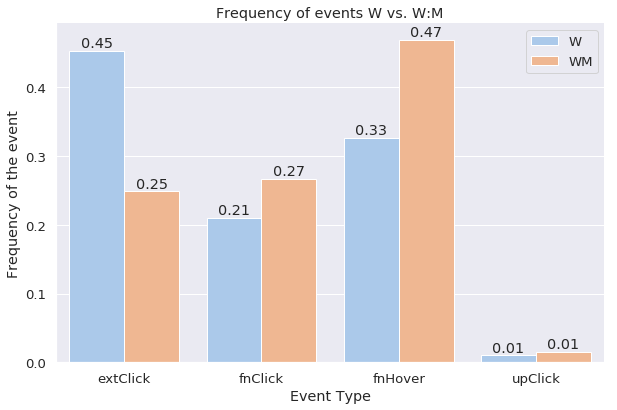

In [102]:
sns.set(font_scale=1.2)

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.005
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


fig = sns.catplot(y='perc', x='action', hue='group', 
                data=events_by_group, 
                kind='bar', palette="pastel", legend=False)
fig.ax.set(xlabel='Event Type', ylabel='Frequency of the event', title="Frequency of events W vs. W:M")
fig.ax.ticklabel_format(style='plain', axis='y')
plt.gcf().set_size_inches(10, 6)
plt.legend(loc='upper right')

show_values_on_bars(fig.ax)

